In [1]:
%load_ext autoreload
%autoreload 2
import torch
import numpy as np
import os
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
from configs import project_config
from configs.RecursiveVPSDE.Markovian_fBiPotDDims_NonSep.recursive_Markovian_PostMeanScore_fBiPot8DimsNS_T256_H05_tl_110data_StbleTgt_FULLDATA  import get_config

In [2]:
from IPython.core.magic import register_cell_magic

@register_cell_magic
def skip(line, cell):
    return

In [3]:
def rmse_ignore_nans(y_true, y_pred):
    return np.nanmean((y_true-y_pred)**2)

def plot_ewma_losses(epochs, losses):
    start_idx = 00
    def compute_ema(loss_tensor, beta):
        ema_values = np.zeros_like(loss_tensor)  # Initialize EMA tensor
        ema_values[0] = loss_tensor[0]  # First value stays the same

        for i in range(1, len(loss_tensor)):
            ema_values[i] = beta * ema_values[i - 1] + (1 - beta) * loss_tensor[i]

        return ema_values
    # Define EMA decay rates
    beta_short = 0.9   # Short-term trend (reacts quickly)
    beta_long = 0.99   # Long-term trend (smoother)

    # Compute EMAs
    short_term_ema = compute_ema(losses, beta_short)
    long_term_ema = compute_ema(losses, beta_long)
    plt.scatter(epochs[start_idx:], (short_term_ema[start_idx:]),s=2, label="Short Term Loss")
    plt.yscale("log")
    plt.legend()
    plt.show()
    plt.scatter(epochs[start_idx:], (long_term_ema[start_idx:]),s=2, label="Long Term Loss")
    plt.yscale("log")
    plt.legend()
    plt.show()


In [4]:
config = get_config()
deltaT = config.deltaT
root_dir ="/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/"
print(config.loss_factor)

2


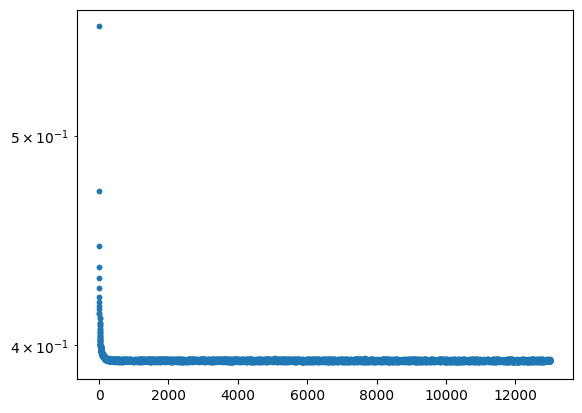

12999

In [5]:
with open(config.scoreNet_trained_path.replace("/trained_models/", "/training_losses/") + "_loss", 'rb') as f:
        losses = (np.array(pickle.load(f)).astype(float))
Nepochs_losses = np.arange(losses.shape[0])
plt.scatter(Nepochs_losses,  losses, s=10)
plt.yscale("log")
plt.show()
plt.close()
Nepochs_losses[-1]

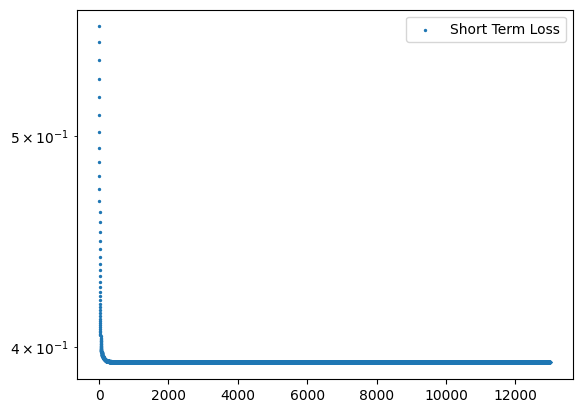

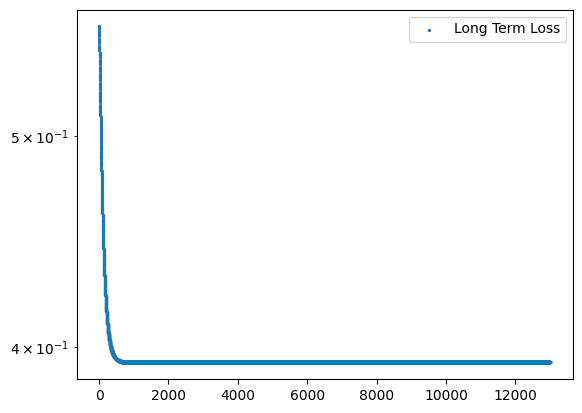

In [6]:
plot_ewma_losses(epochs=Nepochs_losses, losses=losses)

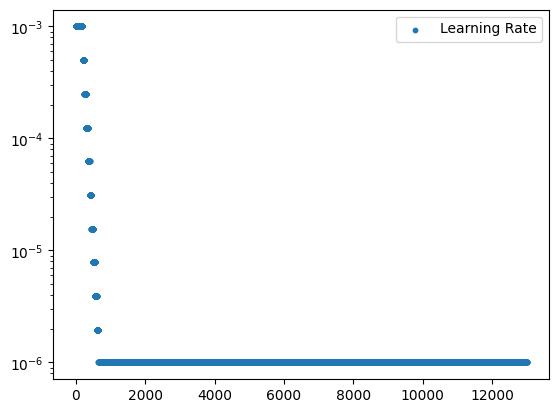

1e-06


In [7]:
with open(config.scoreNet_trained_path.replace("/trained_models/", "/training_losses/") + "_loss_LR", 'rb') as f:
        LRs = (np.array(pickle.load(f)).astype(float))
start = 0#935
end = -1#935+152
plt.scatter(Nepochs_losses[start:end],  LRs[start:end], s=10, label="Learning Rate")
plt.yscale("log")
plt.legend()
plt.show()
plt.close()
print(LRs[-1])

In [8]:
def get_drift_files(config, ts_type):
    root_score_dir = root_dir + f"ExperimentResults/TSPM_Markovian/8DDimsNS/"
    driftoostrack_true_files = []
    driftoostrack_local_files = []
    for file in os.listdir(root_score_dir):
        if "_MLP_" in file and ts_type in file:
            if "DriftTrack" in file and "true" in file:
                driftoostrack_true_files.append(root_score_dir+file)
            elif "DriftTrack" in file and "global" in file:
                driftoostrack_local_files.append(root_score_dir+file)
    assert len(driftoostrack_true_files)>0, "No oos drift track files found"
    assert len(driftoostrack_local_files)>0, "No oos drift track files found"
    assert(len(driftoostrack_true_files) == len(driftoostrack_true_files))
    def extract_bw_drift_track_number(s):
        match = s.split("Nep_")[0].split("_")[-1]
        return int(match)
    driftoostrack_true_files = sorted(driftoostrack_true_files, key=extract_bw_drift_track_number)
    driftoostrack_local_files = sorted(driftoostrack_local_files, key=extract_bw_drift_track_number)
    Nepochs_track = [extract_bw_drift_track_number(f) for f in driftoostrack_true_files]
    return driftoostrack_true_files, driftoostrack_local_files, Nepochs_track

In [9]:
ts_type = f"{config.ndims}DDimsNS".replace(".", "")
#drift_true_files, drift_local_files, Nepochs_track = get_drift_files(config=config, ts_type=ts_type)
#len(Nepochs_track)
#print(drift_true_files)

In [10]:
drift_track_rmses = {}
epochs_iter = Nepochs_track
Nepochs_keep = []
for Nepoch, true, local in zip(*[epochs_iter, drift_true_files, drift_local_files]):
    try:
        print(str(Nepoch), str(Nepoch)[-1])
        all_true_states = np.load(true)
        all_local_states= np.load(local)
        time_steps = np.linspace(config.t0,config.deltaT*all_true_states.shape[2],all_true_states.shape[2])
        all_global_errors = np.sum(np.power(all_true_states- all_local_states,2), axis=-1)
        all_global_errors=all_global_errors.reshape(-1, all_global_errors.shape[-1])            # (K, N, T)
        total_local_errors = np.sqrt(np.mean(all_global_errors, axis=(0)))/np.sqrt(time_steps)
        all_paths_err = np.sqrt(all_global_errors)/np.sqrt(time_steps)
        total_local_errors[total_local_errors==np.inf] = 0.
        all_paths_err[all_paths_err==np.inf] = 0.
        drift_track_rmses.update({Nepoch:total_local_errors[-1]})
        Nepochs_keep.append(Nepoch)
    except (FileNotFoundError, ValueError, TimeoutError) as e:
        #del all_true_states, all_local_states, all_local_errors, total_local_errors
        continue
Nepochs_track = Nepochs_keep
drift_track_rmses

2 2



KeyboardInterrupt



In [10]:
with open(config.scoreNet_trained_path.replace("/trained_models/", "/training_losses/") + "_loss", 'rb') as f:
        losses = np.array(pickle.load(f)).astype(float)
Nepochs_losses = np.arange(losses.shape[0])
print(Nepochs_losses)

[    0     1     2 ... 12997 12998 12999]


In [11]:
import pandas as pd
root_score_dir = root_dir + f"ExperimentResults/TSPM_Markovian/8DDimsNS/"
mses=[]
for file in os.listdir(root_score_dir):
    if "MSE" in file:
        mses.append(pd.read_parquet(root_score_dir+file, engine="fastparquet"))
mses = pd.concat(mses).reset_index(drop=False).rename({"index":"epoch"}, axis=1).sort_values("epoch").reset_index(drop=True)
Nepochs_track = mses["epoch"].values.flatten()

In [12]:
common_epochs = np.intersect1d(Nepochs_losses, Nepochs_track)
common_epochs = np.intersect1d(common_epochs, np.arange(10, 8000))
start_idx = 0
common_epochs = common_epochs[start_idx:]
losses_idx = np.unique([np.argwhere(c == Nepochs_losses)[0,0] for c in common_epochs])
track_idx = np.unique([np.argwhere(c == Nepochs_track)[0,0] for c in common_epochs])
red_losses = losses[losses_idx]
print(track_idx.shape, common_epochs.shape)
#track_rmses = np.array(list(drift_track_rmses.values()))[track_idx]
track_rmses = mses.iloc[track_idx,:].mse.values.flatten()
print(track_rmses.shape, common_epochs.shape)

(7990,) (7990,)
(7990,) (7990,)


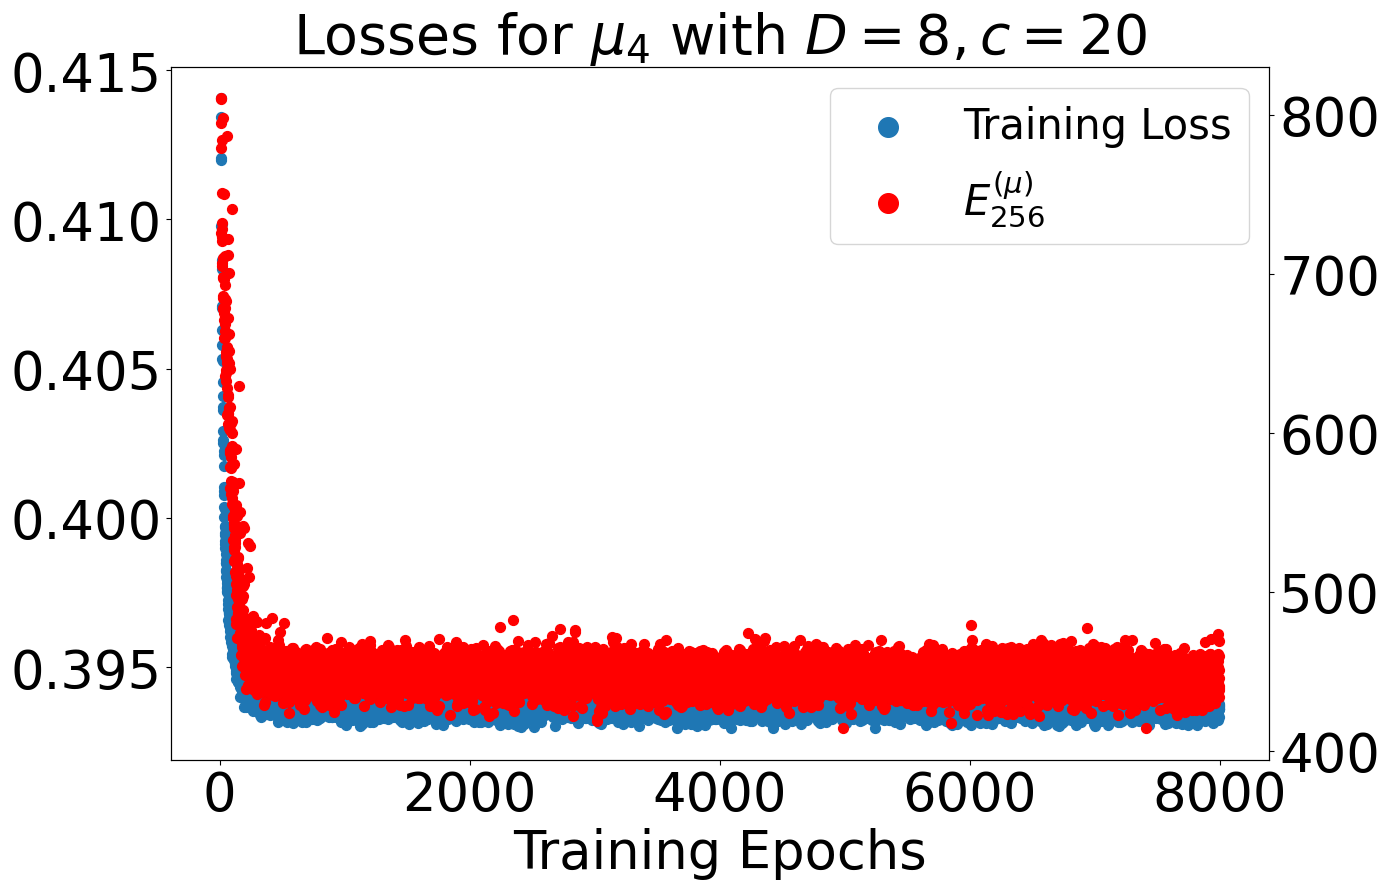

In [14]:
toSave = True
fig, ax = plt.subplots(figsize=(14,9))
max_idx = np.argwhere(common_epochs <=13000).flatten()[-1]
sc1 = ax.scatter(common_epochs[:max_idx+1], red_losses[:max_idx+1], s=50, label="Training Loss")
ax2 = ax.twinx()
sc2 = ax2.scatter(common_epochs[:max_idx+1], track_rmses[:max_idx+1], s=50, color="red",label="$E^{(\mu)}_{256}$")
ax.set_xlabel("Training Epochs", fontsize=38)
ax.set_title(r"Losses for $\mu_{4}$ with $D=8, c=20$", fontsize=40)
ax.tick_params(axis="both",labelsize=38)
ax2.tick_params(axis="both",labelsize=38)
plt.tight_layout()
handles = [sc1, sc2]
labels = [h.get_label() for h in handles]
# Add a single legend on ax1
ax.legend(handles, labels, fontsize=30, markerscale=2)
if toSave:
    plt.savefig((root_dir + f"DiffusionModelPresentationImages/TSPM_Markovian/8DDimsNS/TSPM_MLP_PM_ST_{config.feat_thresh:.3f}FTh_fBiPot_{config.ndims}DDimsNS_LossesTrack_{config.loss_factor}LFac").replace(".","")+".png",  bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
curr_rmse = np.inf
toSave = True
for f_idx in range(len(common_epochs)):
    Nepoch = common_epochs[f_idx]
    ff_idx = np.argwhere(Nepoch == np.array(epochs_iter))[0,0]
    true = drift_true_files[ff_idx]
    local = drift_local_files[ff_idx]
    try:
        if Nepoch < 5: raise FileNotFoundError
        num_diff_times = 1
        all_true_states = np.load(true)
        all_local_states= np.load(local)
        print(all_local_states.shape)
        time_steps = np.linspace(config.t0,config.deltaT*all_true_states.shape[2],all_true_states.shape[2])
        all_global_errors = np.sum(np.power(all_true_states- all_local_states,2), axis=-1)
        all_global_errors=all_global_errors.reshape(-1, all_global_errors.shape[-1])            # (K, N, T)
        total_local_errors = np.sqrt(np.mean(all_global_errors, axis=(0)))/np.sqrt(time_steps)
        all_paths_err = np.sqrt(all_global_errors)/np.sqrt(time_steps)
        total_local_errors[total_local_errors==np.inf] = 0.
        all_paths_err[all_paths_err==np.inf] = 0.
        total_local_errors_minq, total_local_errors_maxq  = np.quantile(all_paths_err, q=[0.005, 0.995], axis=0) # (T,)<
        if total_local_errors[-1] < curr_rmse:
            curr_rmse = total_local_errors[-1]
            fig, ax = plt.subplots(figsize=(14,9))
            plt.grid(True)
            ax.scatter(time_steps, total_local_errors)
            plt.fill_between(time_steps,y1=total_local_errors_minq, y2=total_local_errors_maxq, color="blue", alpha=0.4)
            ax.set_title(rf"Pathwise RMSE for Score Estimator $\mu_4$",fontsize=40)
            ax.set_ylabel("RMSE", fontsize=38)
            ax.set_xlabel("Time Axis", fontsize=38)
            ax.tick_params(labelsize=38)
            plt.tight_layout()
            if toSave:
                plt.savefig((root_dir + f"DiffusionModelPresentationImages/TSPM_Markovian/8DDimsNS/TSPM_MLP_PM_ST_{config.feat_thresh:.3f}FTh_fBiPot_{config.ndims}DDimsNS_DriftTrack_{Nepoch}Nep_{round(total_local_errors_minq[-1], 8)}_MinIQR_{round(total_local_errors[-1], 8)}MeanIQR_{round(total_local_errors_maxq[-1], 8)}_MaxIQR").replace(".", "")+".png")
            plt.show()
            plt.close()
            print(f"Final time cumulative MSE local-time error {total_local_errors[-1]} with final IQR {(total_local_errors_minq[-1], total_local_errors_maxq[-1])} at Nepoch {Nepoch}\n")
    except FileNotFoundError as e:
        continue

In [ ]:
from utils.resource_logger import wallclock_and_system_metrics
data = wallclock_and_system_metrics(config.resource_logging_path, inclusive=True)
data

In [ ]:
24.019614780590+2.427880978